In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-fr7wjjg1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-fr7wjjg1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 28fd05eeb68114aa8a8d915168bdf6e7f7b5c2a6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

Running detection using model: COCO-Detection/faster_rcnn_R_101_C4_3x.yaml
Model COCO-Detection/faster_rcnn_R_101_C4_3x.yaml detected 8 objects.
Running detection using model: COCO-Detection/faster_rcnn_R_50_C4_3x.yaml
Model COCO-Detection/faster_rcnn_R_50_C4_3x.yaml detected 10 objects.


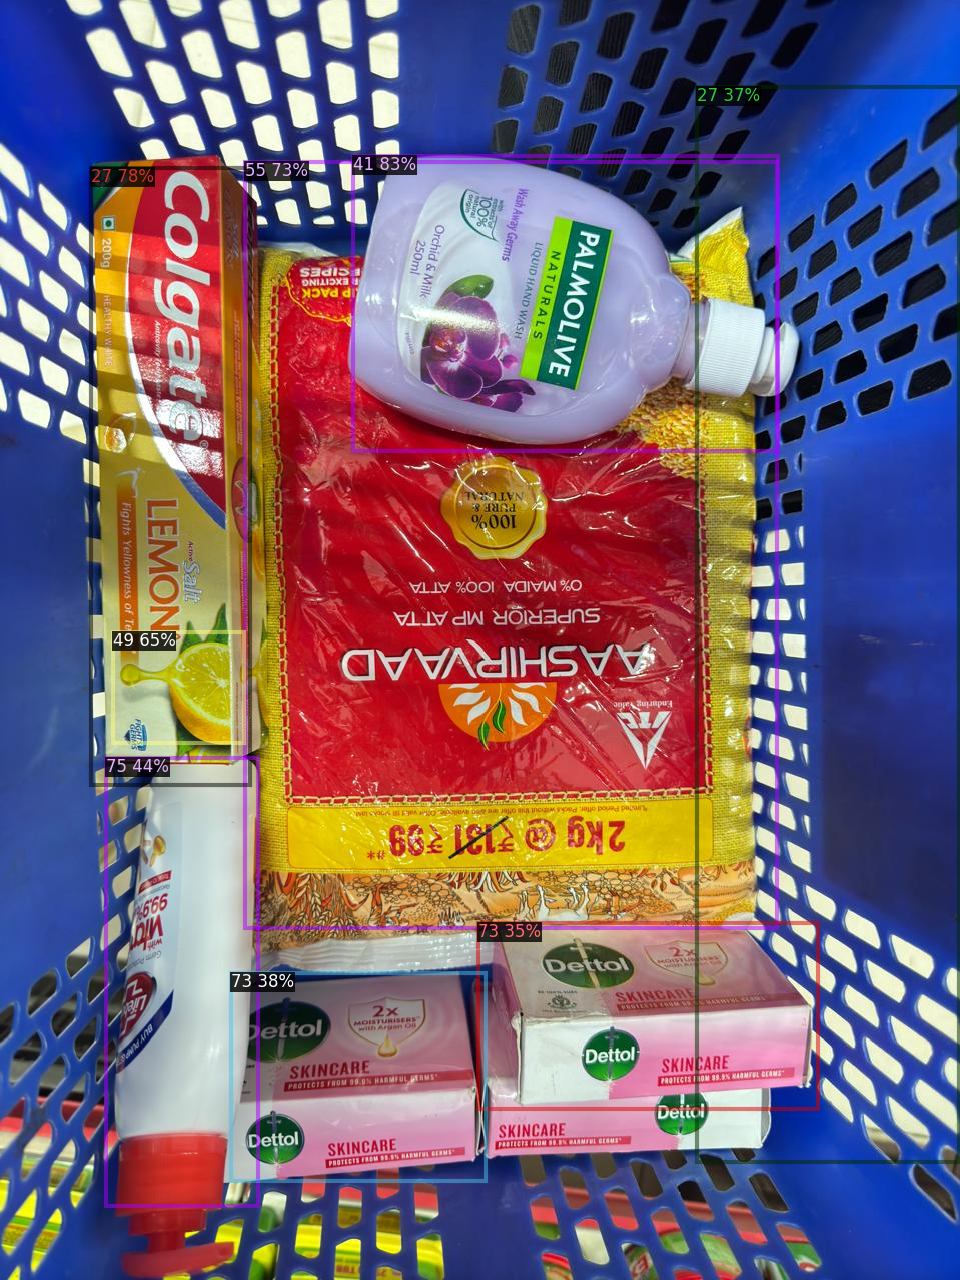

Total number of detected objects after filtering duplicates: 8


In [21]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Boxes, pairwise_iou
from google.colab.patches import cv2_imshow
import torch
import cv2
import numpy as np

# List of two pre-trained Faster R-CNN models from Detectron2
model_configs = [
    "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml",
    "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"
]

# Load the image
img = cv2.imread("/content/test-img-2.jpeg")

# Store all bounding boxes and classes from both models
all_boxes = []
all_scores = []
all_classes = []

# Loop through the models and run detection for each one
for model_config in model_configs:
    print(f"Running detection using model: {model_config}")

    # Load configuration and pre-trained weights for each model
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_config))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.32  # Threshold for object detection

    # Set device to CPU
    cfg.MODEL.DEVICE = "cpu"  # Change this to 'cuda' if you want to use GPU

    # Initialize the predictor for the current model
    predictor = DefaultPredictor(cfg)

    # Run the prediction
    outputs = predictor(img)

    # Get the detected instances, bounding boxes, classes, and scores
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    scores = instances.scores.cpu().numpy()
    classes = instances.pred_classes.cpu().numpy()

    # Store the detected bounding boxes, scores, and classes
    all_boxes.append(boxes)
    all_scores.append(scores)
    all_classes.append(classes)

    print(f"Model {model_config} detected {len(boxes)} objects.")

# Merge all detections from both models
merged_boxes = np.vstack(all_boxes)  # Stack all bounding boxes
merged_scores = np.hstack(all_scores)  # Combine all scores
merged_classes = np.hstack(all_classes)  # Combine all class predictions

# Convert boxes to a Detectron2 Boxes object
merged_boxes_d2 = Boxes(torch.tensor(merged_boxes))

# IoU-based duplicate removal
iou_threshold = 0.35  # IoU threshold for merging duplicate boxes
keep_indices = []  # To store indices of boxes we want to keep

# Compare all boxes pairwise
for i in range(len(merged_boxes)):
    keep = True
    for j in keep_indices:
        iou = pairwise_iou(Boxes(torch.tensor(merged_boxes[i:i+1])), Boxes(torch.tensor(merged_boxes[j:j+1]))).item()
        if iou > iou_threshold:
            # If the IoU is above the threshold, it's a duplicate, don't keep it
            keep = False
            break
    if keep:
        keep_indices.append(i)

# Keep only the non-duplicate boxes, scores, and classes
filtered_boxes = merged_boxes[keep_indices]
filtered_scores = merged_scores[keep_indices]
filtered_classes = merged_classes[keep_indices]

# Create the final output using the filtered detections
final_instances = Instances(image_size=img.shape[:2])
final_instances.pred_boxes = Boxes(torch.tensor(filtered_boxes))  # Merge boxes
final_instances.scores = torch.tensor(filtered_scores)  # Merge scores
final_instances.pred_classes = torch.tensor(filtered_classes)  # Merge classes

# Visualize the final merged output
v = Visualizer(img[:, :, ::-1])
out = v.draw_instance_predictions(final_instances.to("cpu"))

# Display the final image with bounding boxes and detected objects from both models
cv2_imshow(out.get_image()[:, :, ::-1])

print(f"Total number of detected objects after filtering duplicates: {len(filtered_boxes)}")
